Load the dataset

In [12]:
import pandas as pd
import os

path = os.path.join('..','results','dataset_with_noNA.csv')
wide_standardized_noNA = pd.read_csv(path)
wide_standardized_noNA['Date'] = pd.to_datetime(wide_standardized_noNA['Date'])

wide_standardized_noNA.head()

,Date,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06 21:00:00,0.325737,-2.141435,-1.511963,0.257900,-2.441477,-2.385681,-2.486445,2.486754,2.639974,2.497832
1,2022-01-06 22:00:00,-0.055789,-0.447794,-0.837576,0.085235,-2.441477,-2.385681,-2.486445,2.402577,2.513033,2.462639
2,2022-01-06 23:00:00,0.230586,-1.294615,-1.039892,0.310450,-2.441477,-2.385681,-2.486445,2.276312,2.534747,2.501964
3,2022-01-07 00:00:00,0.073282,-0.730068,-1.606377,0.248516,-2.441477,-2.385681,-2.486445,2.297356,2.568152,2.494586
4,2022-01-07 01:00:00,0.261105,-1.953253,-1.417549,0.216610,-2.441477,-2.385681,-2.486445,2.465709,2.586525,2.486839


Cluster days together using K-Means

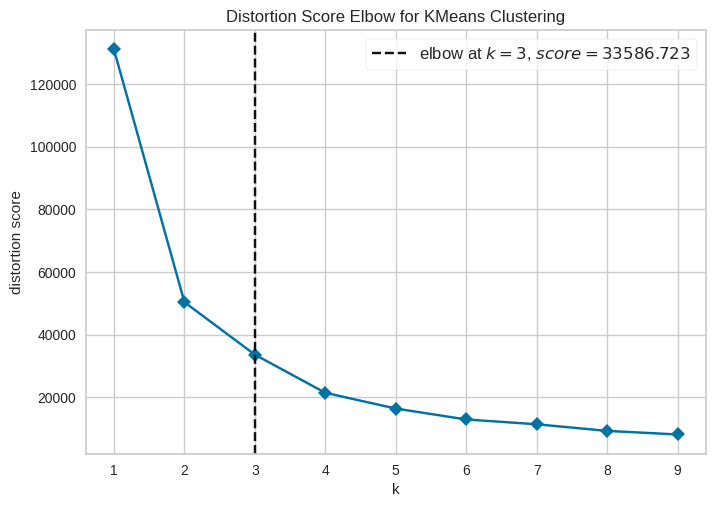

In [2]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Removing the 'Date' column as it's not relevant for clustering
clustering_df = wide_standardized_noNA.drop('Date', axis=1)

# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 'auto', random_state=123)
    kmeans.fit(clustering_df)
    wcss.append(kmeans.inertia_)

kmeans = KMeans(init='k-means++', n_init='auto', random_state=123)
visualizer = KElbowVisualizer(kmeans, k=(1,10), timings=False)
visualizer.fit(clustering_df)
visualizer.show()
plt.show()

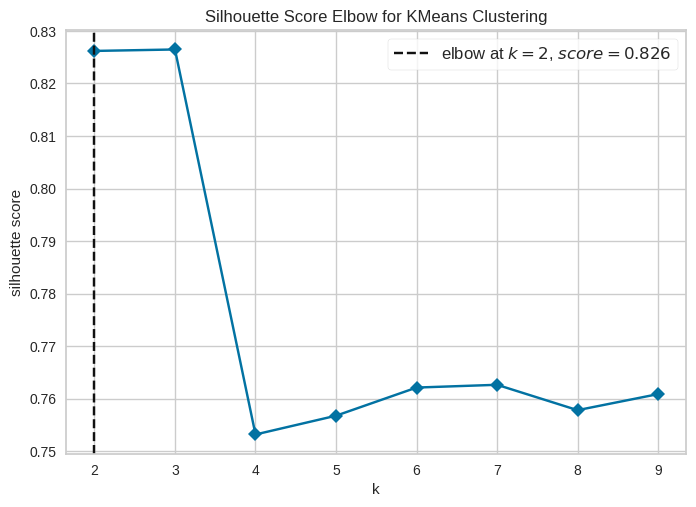

In [3]:
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric='silhouette', timings=False)
visualizer.fit(clustering_df)
visualizer.show()
plt.show()

Cluster days together using DBSCAN

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product

# DBSCAN clustering
# We need to specify the epsilon (eps) and minimum samples (min_samples) parameters
# We will seek optimal ones by grid hyperparameter tuning
eps_values = range(1,8,2) # eps values to be investigated
min_samples = range(3,12,2) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(clustering_df)
    no_of_clusters.append(len(set(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(clustering_df, DBS_clustering.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns = ['Eps', 'Min. samples'])   
tmp['Silhouette score'] = sil_score

dbscan_tuning = tmp.pivot(index='Eps', columns='Min. samples', values='Silhouette score')
dbscan_tuning

Min. samples,3,5,7,9,11
Eps,,,,,
1,0.695260,0.696355,0.695738,0.770972,0.766900
3,0.831334,0.827545,0.827493,0.830291,0.829508
5,0.831077,0.830416,0.830416,0.830416,0.829673
7,0.833449,0.832668,0.832668,0.832668,0.900558


In [6]:
tmp['n of clusters'] = no_of_clusters

dbscan_nclusters = tmp.pivot(values='n of clusters', columns='Min. samples', index='Eps')
dbscan_nclusters

Min. samples,3,5,7,9,11
Eps,,,,,
1,8,6,5,4,4
3,7,5,5,4,3
5,6,4,4,4,3
7,5,3,3,3,2


Perform Partial Component Analysis with 2 components so we can plot the clusters in 2D PCA space and print PCA loadings

In [7]:
from sklearn.decomposition import PCA

# Performing PCA with 2 components
pca = PCA(n_components=2, random_state=123)
pca_df = pca.fit_transform(clustering_df)

# The factor loadings (how much each variable contributes to each factor)
pca_loadings = pd.DataFrame(pca.components_, columns=clustering_df.columns)

pca_loadings

,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,0.008088,-0.144923,-0.191145,-0.005338,-0.395948,-0.389255,-0.398772,0.396239,0.398595,0.398963
1,-0.687674,-0.037752,-0.161906,-0.704673,-0.000351,0.005890,-0.009569,-0.031779,-0.029367,-0.030035


Cluster analysis 2D Plots

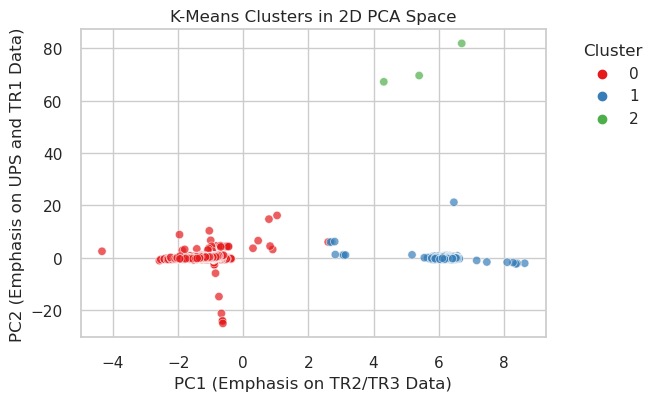

In [8]:
import seaborn as sns

plotting_df = wide_standardized_noNA.copy()

kmeans_k3 = KMeans(n_clusters=3, init='k-means++', n_init = 'auto', random_state=123)
plotting_df['K-Means Cluster'] = kmeans_k3.fit_predict(clustering_df)

# Set the Seaborn style
sns.set(style="whitegrid")

# Plotting the results with Seaborn
plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], hue=plotting_df['K-Means Cluster'], palette='Set1', alpha=0.7)

plt.xlabel('PC1 (Emphasis on TR2/TR3 Data)')
plt.ylabel('PC2 (Emphasis on UPS and TR1 Data)')
plt.title('K-Means Clusters in 2D PCA Space')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

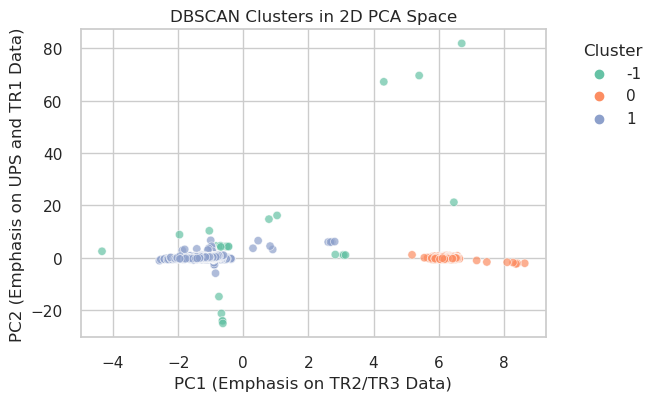

In [9]:
dbscan_k3 = DBSCAN(eps=5, min_samples=11)
plotting_df['DBSCAN Cluster'] = dbscan_k3.fit_predict(clustering_df)

# Plotting the results with Seaborn
plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], hue=plotting_df['DBSCAN Cluster'], palette='Set2', alpha=0.7)

plt.xlabel('PC1 (Emphasis on TR2/TR3 Data)')
plt.ylabel('PC2 (Emphasis on UPS and TR1 Data)')
plt.title('DBSCAN Clusters in 2D PCA Space')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

Labeling clusters based on the PCA/Cluster 2D plots

Plot dates on the x-axis and cluster groups on the y-axis

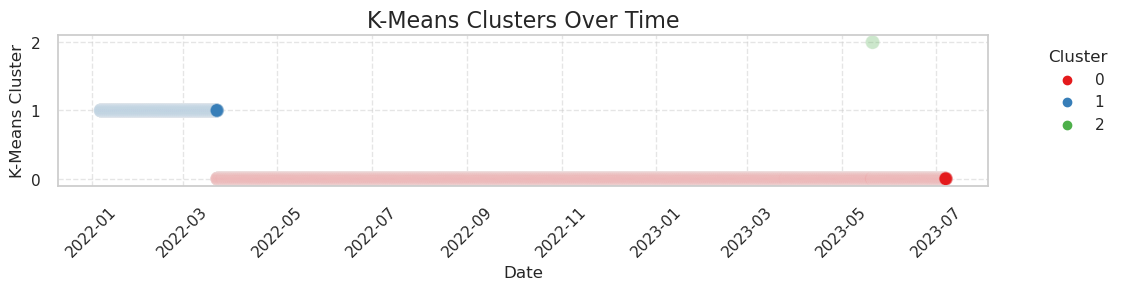

In [10]:
plt.figure(figsize=(12, 1.95))

# Scatter plot with an aesthetically pleasing color palette
scatter = sns.scatterplot(data=plotting_df, x='Date', y='K-Means Cluster', 
                          hue='K-Means Cluster', palette='Set1', alpha=0.1, s=100)

# Enhance readability and aesthetics
plt.title('K-Means Clusters Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('K-Means Cluster')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Format the date axis for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())

# Adding a legend with a title and adjusting its position
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()

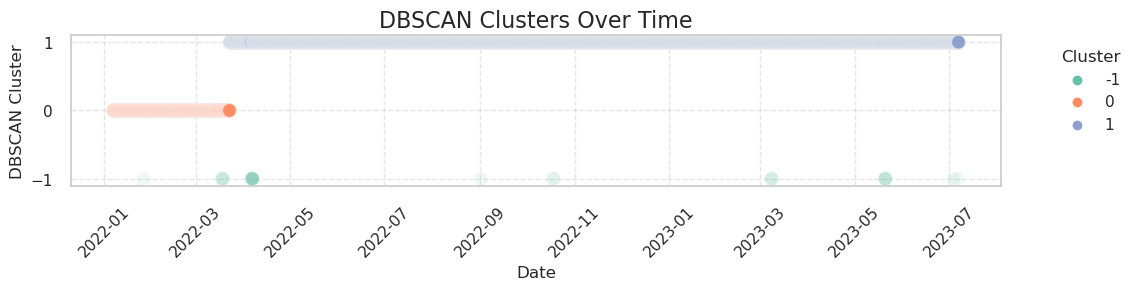

In [11]:
plt.figure(figsize=(12, 1.95))

# Scatter plot with an aesthetically pleasing color palette
scatter = sns.scatterplot(data=plotting_df, x='Date', y='DBSCAN Cluster', 
                          hue='DBSCAN Cluster', palette='Set2', alpha=0.1, s=100)

# Enhance readability and aesthetics
plt.title('DBSCAN Clusters Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('DBSCAN Cluster')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Format the date axis for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())

# Adding a legend with a title and adjusting its position
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()